# Tweet Classification 
### Used different Machine learning models from base to advance.

In [1]:
import os
import re
import string
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator
import spacy
import nltk
import unidecode
from nltk.corpus import stopwords
import numpy as np 
import pandas as pd 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import dill
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
import logging
from simpletransformers.classification import ClassificationModel

In [2]:
train_df = pd.read_csv('../Dataset/Disaster Tweets/train.csv')
test_df = pd.read_csv('../Dataset/Disaster Tweets/test.csv')
submission = pd.read_csv('../Dataset/Disaster Tweets/sample_submission.csv')

In [3]:
train_df[train_df['target']==1]['text'].values[:3]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"],
      dtype=object)

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
train_has_keyword_df = train_df[train_df.keyword.notnull()]
train_has_location_df = train_df[train_df.location.notnull()]
print(len(train_has_keyword_df))

7552


In [9]:
train_has_keyword_df.head(10)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1
38,56,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1
39,57,ablaze,Paranaque City,Ablaze for you Lord :D,0
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0


C:\Users\91903\anaconda3\envs\kali\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


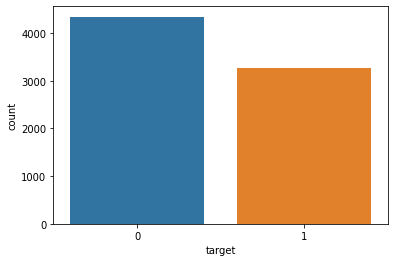

In [10]:
import seaborn as sns
ax = sns.countplot(train_df['target'])

## WordCloud

In [11]:
def renderWordcloud(text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    F = plt.gcf()
    Size = F.get_size_inches()
    F.set_size_inches(Size[0]*2, Size[1]*2, forward=True) # Set forward to True to resize window along with plot in figure.
    plt.show()

### WordCloud of Keywords

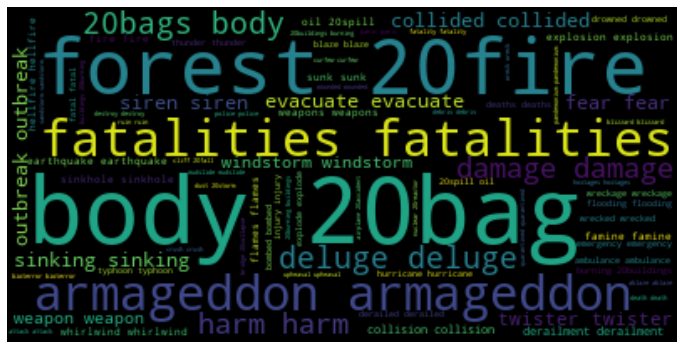

In [12]:
text = " ".join(keyword for keyword in train_has_keyword_df.keyword)
renderWordcloud(text)

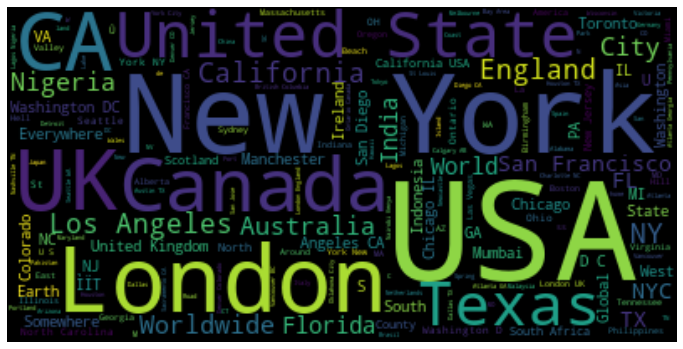

In [13]:
text = " ".join(keyword for keyword in train_has_location_df.location)
renderWordcloud(text)

### Unique Words

In [14]:
len(train_has_keyword_df.keyword.unique()), len(train_has_location_df.location.unique())

(221, 3341)

## Cleaning Textual Data


### Remove Stop Words

In [15]:
# nltk.download('stopwords')
stop = stopwords.words('english')
# print(stop)
def remove_stop(text):
    a = []
    b = text.split(" ")
    for i in b: 
        if i not in stop:
            a.append(i)
    a = " ".join(a)
    return a
remove_stop("Our Deeds are the Reason of this ")

'Our Deeds Reason '

In [16]:
train_df['text'] = train_df['text'].apply(lambda x : remove_stop(x))
test_df['text'] = test_df['text'].apply(lambda x : remove_stop(x))

#### Removing URL

In [17]:
example = "www.heloo.com wassss upppp bittcchhhh https://helllooo"
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

' wassss upppp bittcchhhh '

In [18]:
train_df['text']= train_df['text'].apply(lambda x : remove_URL(x))

In [19]:
test_df['text'] = test_df['text'].apply(lambda x: remove_URL(x))

#### Removing Emojis

In [20]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [21]:
train_df['text'] = train_df['text'].apply(lambda x : remove_emoji(x))

In [22]:
test_df['text'] = train_df['text'].apply(lambda x : remove_emoji(x))

#### Removing Punctuations

In [23]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)


In [24]:
train_df['text'] = train_df['text'].apply(lambda x : remove_punct(x))

In [25]:
test_df['text'] = test_df['text'].apply(lambda x : remove_punct(x))


In [26]:
train_df.head(-10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds Reason earthquake May ALLAH Forgive us,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked shelter place notified off...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1
...,...,...,...,...,...
7598,10853,NaN,NaN,Fatherofthree Lost Control Car After Overtakin...,1
7599,10854,NaN,NaN,13 Earthquake 9Km Ssw Of Anza California iPhon...,1
7600,10855,NaN,NaN,Evacuation order lifted town Roosevelt,1
7601,10859,NaN,NaN,breaking LA Refugio oil spill may costlier big...,1


In [27]:
train_df['text'] = train_df['text'].apply(lambda x : x.lower())
test_df['text'] = test_df['text'].apply(lambda x : x.lower())

### Vectorization for Modelling

#### Count Vectorizer

In [28]:
count_vectorizer = feature_extraction.text.CountVectorizer()

vector_samples = count_vectorizer.fit_transform(train_df["text"][0:5])
print(vector_samples[0].todense().shape)
print(vector_samples[0].todense())

(1, 40)
[[0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 1 0]]


Sample Vectors shows us that there are 40 unique words in the first 5 samples. 
In first sample, 1 denotes the tokens that are there present in the text

In [29]:
list_corpus = train_df["text"].tolist()
list_labels = train_df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=0)
train_vectors = count_vectorizer.fit_transform(X_train)
test_vectors = count_vectorizer.transform(X_test)

### Linear Regression Ridge Classifier with Count Vectorizer

In [30]:
clf = linear_model.RidgeClassifier()
clf.fit(train_vectors, y_train)
predictions = clf.predict(test_vectors)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       886
           1       0.77      0.66      0.71       637

    accuracy                           0.78      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.78      0.78      0.77      1523



#### TFIDF for Vectorization 

In [31]:
tfidf = feature_extraction.text.TfidfVectorizer()
train_vectors_tfidf = tfidf.fit_transform(X_train)
test_vectors_tfidf = tfidf.transform(X_test)

### Linear Regression Ridge Classifier with TFIDF

In [32]:
clf = linear_model.RidgeClassifier()
clf.fit(train_vectors_tfidf, y_train)
predictions = clf.predict(test_vectors_tfidf)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       886
           1       0.81      0.70      0.75       637

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



##### Using Keywords for prediction

In [33]:
train_keyword = train_df.copy()
train_keyword['keyword'] = train_df['keyword'].fillna(" ")

list_corpus = train_keyword["keyword"].tolist()
list_labels = train_keyword["target"].tolist()
  
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=0)


In [34]:
train_keyword.head()

,id,keyword,location,text,target
0,1,,NaN,our deeds reason earthquake may allah forgive us,1
1,4,,NaN,forest fire near la ronge sask canada,1
2,5,,NaN,all residents asked shelter place notified off...,1
3,6,,NaN,13000 people receive wildfires evacuation orde...,1
4,7,,NaN,just got sent photo ruby alaska smoke wildfire...,1


In [35]:
train_vectors_tfidf = tfidf.fit_transform(X_train)
test_vectors_tfidf = tfidf.transform(X_test)

In [36]:
clf = linear_model.RidgeClassifier()
clf.fit(train_vectors_tfidf, y_train)
predictions = clf.predict(test_vectors_tfidf)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       886
           1       0.71      0.62      0.66       637

    accuracy                           0.73      1523
   macro avg       0.73      0.72      0.72      1523
weighted avg       0.73      0.73      0.73      1523



##### Using Keywords + text for classification

In [37]:
train_keyword_text = train_df.copy()
train_keyword_text['keyword'] = train_df['keyword'].fillna(" ")
train_keyword_text['text + keyword'] = train_df['text'] + " // " + train_keyword_text['keyword']

In [38]:
train_keyword_text.head()

,id,keyword,location,text,target,text + keyword
0,1,,NaN,our deeds reason earthquake may allah forgive us,1,our deeds reason earthquake may allah forgive ...
1,4,,NaN,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada //
2,5,,NaN,all residents asked shelter place notified off...,1,all residents asked shelter place notified off...
3,6,,NaN,13000 people receive wildfires evacuation orde...,1,13000 people receive wildfires evacuation orde...
4,7,,NaN,just got sent photo ruby alaska smoke wildfire...,1,just got sent photo ruby alaska smoke wildfire...


In [39]:
list_corpus = train_keyword_text["text + keyword"].tolist()
list_labels = train_keyword_text["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=0)
train_vectors_tfidf = tfidf.fit_transform(X_train)
test_vectors_tfidf = tfidf.transform(X_test)

In [40]:
clf = linear_model.RidgeClassifier()
clf.fit(train_vectors_tfidf, y_train)
predictions = clf.predict(test_vectors_tfidf)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       886
           1       0.80      0.69      0.74       637

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



#### Best Results, are from Ridge Classifier with TFIDF, having textual data as input.

In [41]:
tfidf = feature_extraction.text.TfidfVectorizer()

list_corpus = train_df["text"].tolist()
list_labels = train_df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=0)
train_vectors_tfidf = tfidf.fit_transform(X_train)
test_vectors_tfidf = tfidf.transform(X_test)

clf = linear_model.RidgeClassifier()
pipe = Pipeline([('vectorizer', TfidfVectorizer()),('predictor', clf)])
pipe.fit(X_train,y_train)
predictions = pipe.predict(X_test)

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       886
           1       0.81      0.70      0.75       637

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



### Multliple Models for Classification

In [42]:
from sklearn.base import BaseEstimator
class ClfSwitcher(BaseEstimator):
    def __init__(self, estimator = linear_model.RidgeClassifier()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 
        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

In [43]:
clf = linear_model.RidgeClassifier()
pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')), ('clf', ClfSwitcher())])

parameters = [
    {
        'clf__estimator': [SVC()],
    },
    {
        'clf__estimator': [SGDClassifier()],
    },
    {
        'clf__estimator': [MultinomialNB()],
    },
    {
        'clf__estimator': [linear_model.RidgeClassifier()],
    },
    {
        'clf__estimator': [MLPClassifier(random_state=1, max_iter=200, early_stopping=True)],
    },
    {
        'clf__estimator': [RandomForestClassifier()]
    }
]

os.write(1, b"Starting grid search of models\n")
gscv = GridSearchCV(pipeline, parameters, cv=3, n_jobs=12, return_train_score=True, verbose=3, scoring='f1')
gscv.fit(train_df["text"], train_df["target"])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf', ClfSwitcher())]),
             n_jobs=12,
             param_grid=[{'clf__estimator': [SVC()]},
                         {'clf__estimator': [SGDClassifier()]},
                         {'clf__estimator': [MultinomialNB()]},
                         {'clf__estimator': [RidgeClassifier()]},
                         {'clf__estimator': [MLPClassifier(early_stopping=True,
                                                           random_state=1)]},
                         {'clf__estimator': [RandomForestClassifier()]}],
             return_train_score=True, scoring='f1', verbose=3)

In [44]:
df = pd.DataFrame(gscv.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.035351,0.075914,1.006896,0.010406,SVC(),{'clf__estimator': SVC()},0.603295,0.495037,0.623974,0.574102,0.056541,5,0.965625,0.964921,0.965996,0.965514,0.000446
1,0.219049,0.016516,0.039676,0.001247,SGDClassifier(),{'clf__estimator': SGDClassifier()},0.625970,0.620956,0.681066,0.642664,0.027231,4,0.961102,0.962377,0.963758,0.962412,0.001084
2,0.202712,0.009179,0.042009,0.002944,MultinomialNB(),{'clf__estimator': MultinomialNB()},0.656571,0.633384,0.715719,0.668558,0.034665,1,0.898195,0.881425,0.885238,0.888286,0.007178
3,0.193045,0.009416,0.041008,0.001416,RidgeClassifier(),{'clf__estimator': RidgeClassifier()},0.637650,0.616502,0.688697,0.647616,0.030304,3,0.959465,0.961270,0.958293,0.959676,0.001224
4,51.359436,0.529346,0.034009,0.009630,"MLPClassifier(early_stopping=True, random_stat...",{'clf__estimator': MLPClassifier(early_stoppin...,0.641387,0.639517,0.699179,0.660028,0.027695,2,0.919029,0.914752,0.913471,0.915751,0.002377
5,6.386445,0.341619,0.333739,0.008959,RandomForestClassifier(),{'clf__estimator': RandomForestClassifier()},0.567332,0.514956,0.590759,0.557682,0.031690,6,0.983924,0.987264,0.985301,0.985496,0.001370


#### MultiNomialNB & MLP Classifier performed better than the others

In [45]:
%%time
clf = MultinomialNB()
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('predictor', clf)])

list_corpus = train_df["text"].tolist()
list_labels = train_df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=0)

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test);
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       886
           1       0.81      0.65      0.72       637

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.79      0.79      0.79      1523

Wall time: 92 ms


In [46]:
clf = MLPClassifier(random_state=1, max_iter=200, early_stopping=True)
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('predictor', clf)])

list_corpus = train_df["text"].tolist()
list_labels = train_df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=0)

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test);
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       886
           1       0.82      0.67      0.74       637

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



### Using Fast Text

#### Data Preparation for fast text

In [47]:
pip install fasttext

  Using cached fasttext-0.9.2.tar.gz (68 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-win_amd64.whl size=235461 sha256=5dfb3b42cb6af997030f659d19a8c4ed4235b267747b66d77658d26491c1db56
  Stored in directory: c:\users\91903\appdata\local\pip\cache\wheels\93\61\2a\c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fasttext



In [58]:
#data preparation for fasttext
import io
import fasttext as fastText
list_corpus = train_df["text"].tolist()
list_labels = train_df["target"].tolist()
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=0)
with io.open('training.txt', 'w', encoding = "utf-8") as f:
    for each_text, each_label in zip(X_train, y_train):
        f.writelines(f'__label__{each_label} {each_text}\n')
with io.open('testing.txt', 'w', encoding = "utf-8") as f:
    for each_text, each_label in zip(X_test, y_test):
        f.writelines(f'__label__{each_label} {each_text}\n')

In [91]:
hyper_params = {"lr": 0.01,"epoch": 40, "wordNgrams": 2, "dim": 30}

In [92]:
# Train the model.
model = fastText.train_supervised(input='training.txt', **hyper_params)
print("Model trained with the hyperparameter \n {}".format(hyper_params))

Model trained with the hyperparameter 
 {'lr': 0.01, 'epoch': 40, 'wordNgrams': 2, 'dim': 30}


In [93]:
result = model.test("testing.txt")
result[1]

0.8017071569271176